# BEiT: 视觉BERT预训练模型
2022年微软团队提出

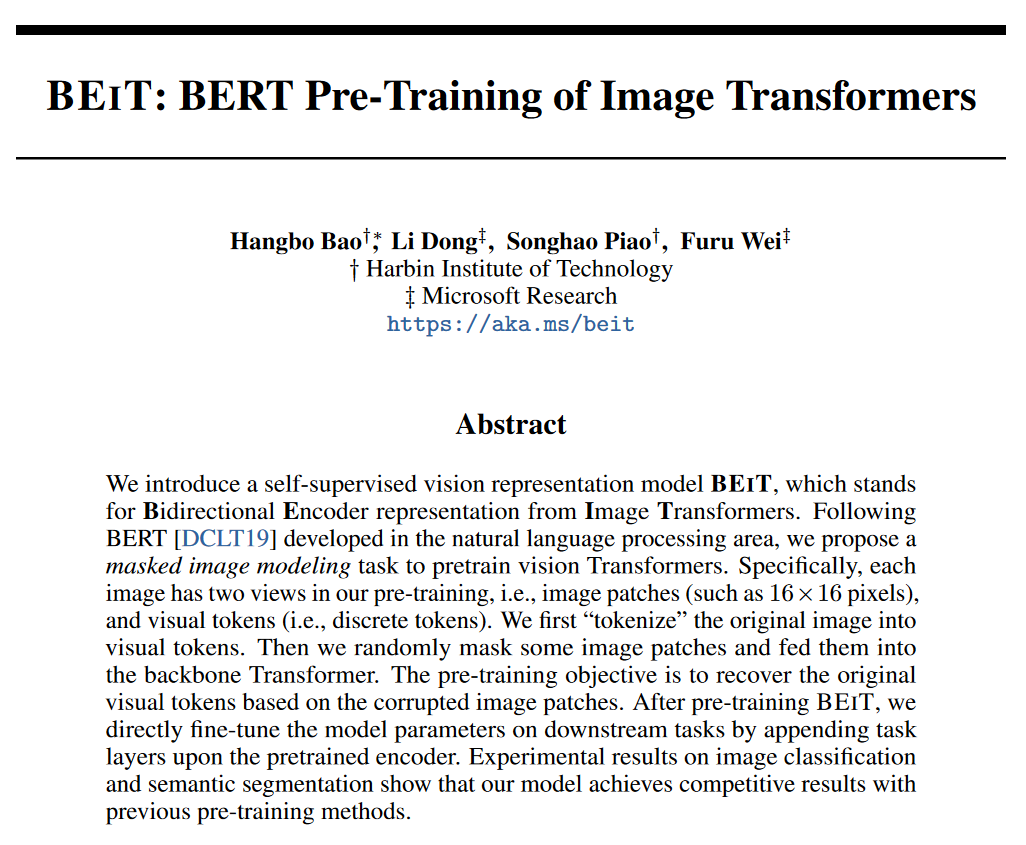

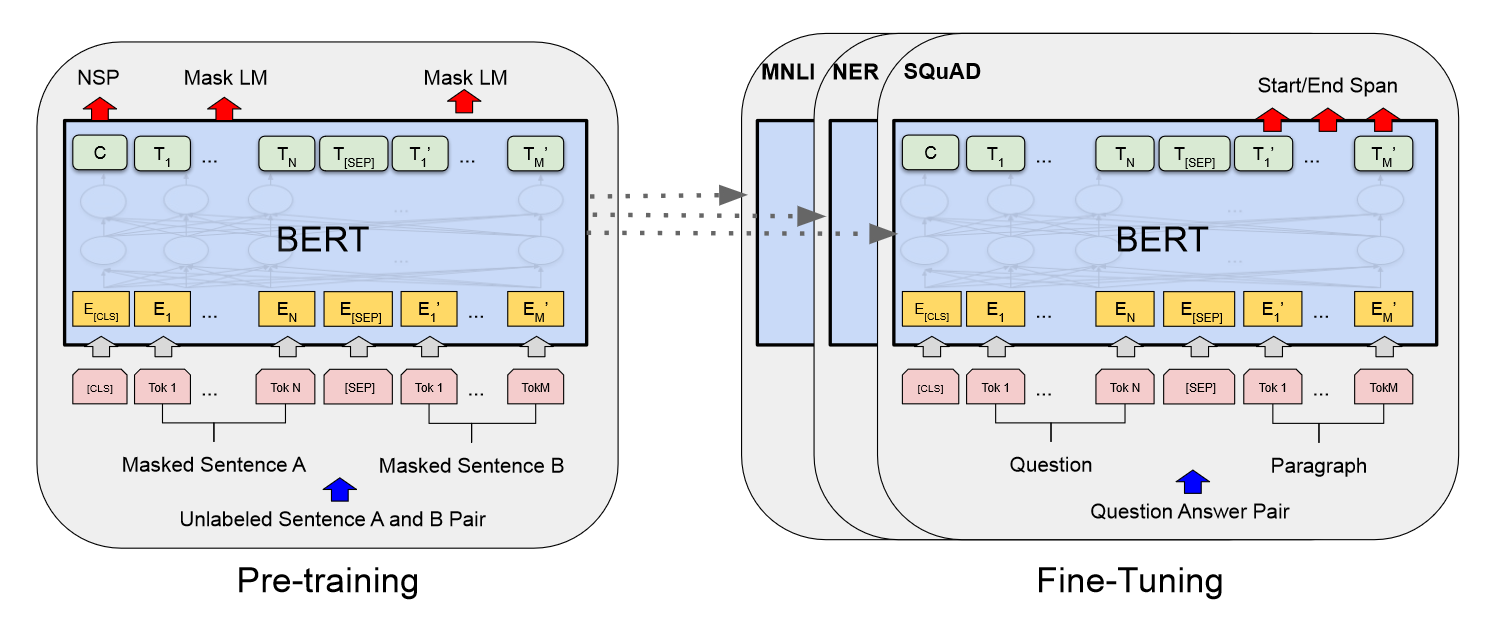

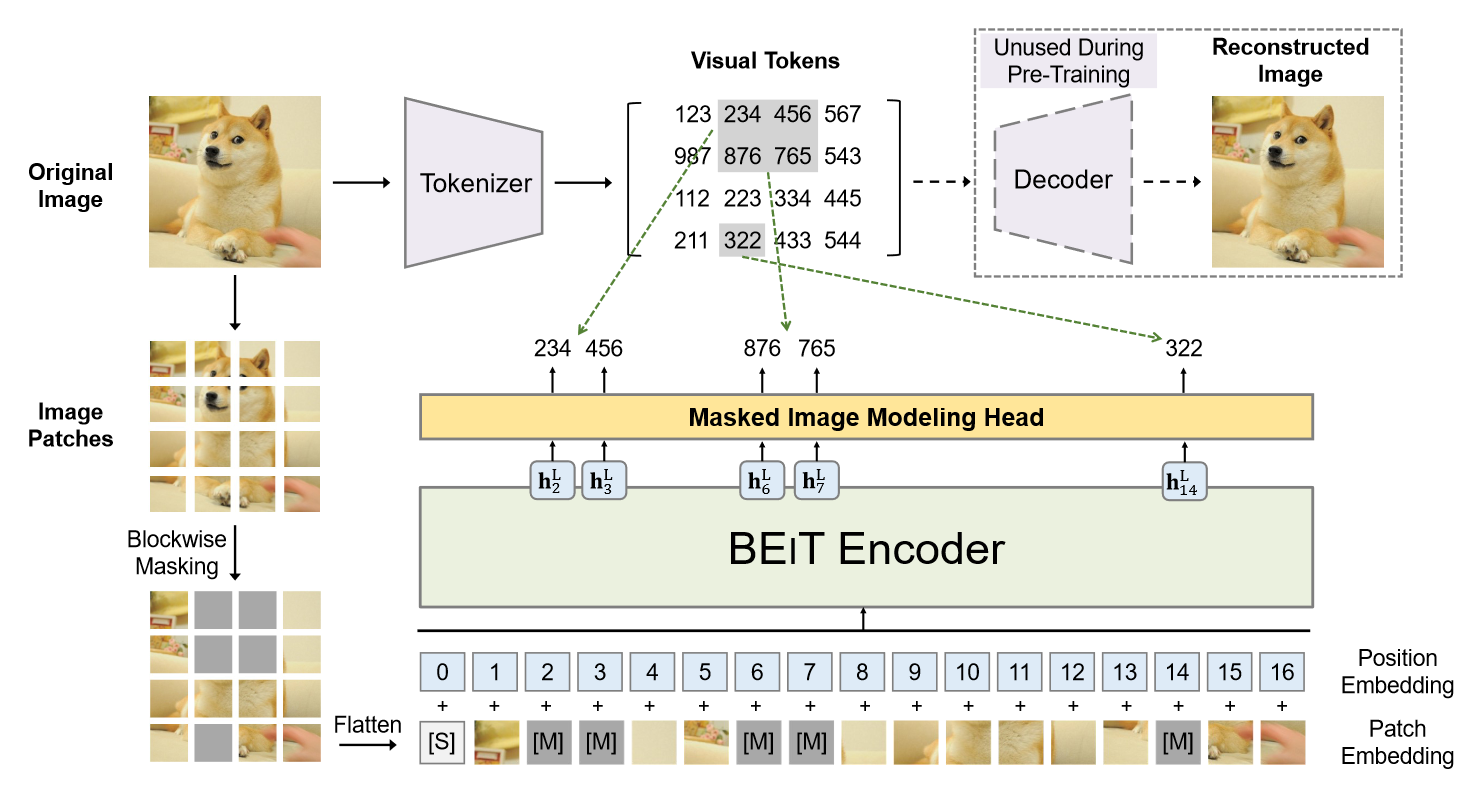

BEiT和BERT的模型思路完全一致，以embedding作为encoder的输入，以token作为自监督的标签，随机mask部分token，任务是预测被mask的token。

但是这个思路放在图像任务中会有一个难点————图像没有词汇表。

BEiT使用dVAE训练得到了visual tokens

### Discrete variational autoencoder
也叫VQ-VAE, vector quantised-VAE, 表示把特征空间离散化。

VQ-VAE的基本思想和框架还是和VAE一样，先快速回顾一下AE和VAE的结构。

#### AE (Auto-Encoder)
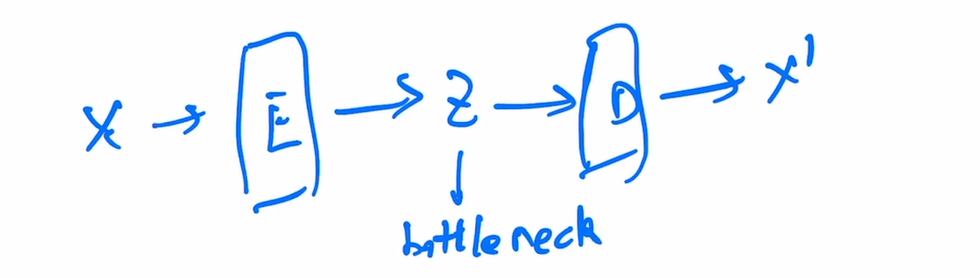
#### DAE (Denoising Auto-Encoder)
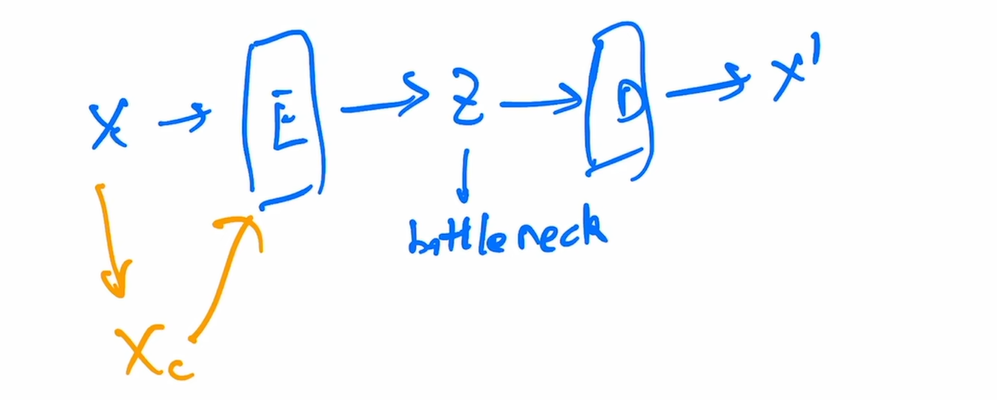

图像像素的冗余性高，在AE的基础上加一个扰动，可以让模型更稳健

但是AE和DAE的目的都是学习bottleneck用于下游任务，比如分类、检测、分割等。Bottleneck只能用来重建，没有随机性，所以无法用来生成。但是encoder-decoder这个结构还是很优秀的~



#### VAE (Variational Auto-encoder)
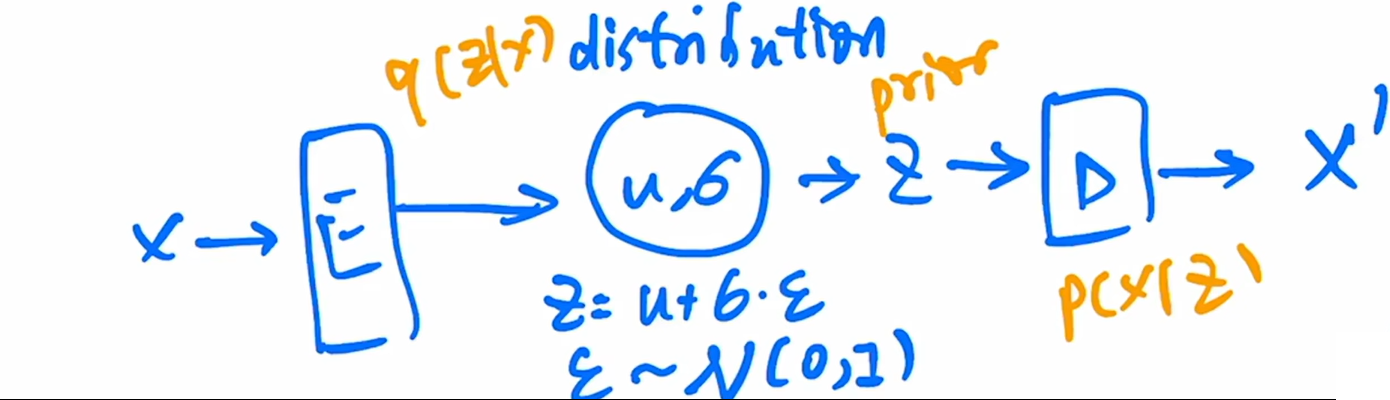
VAE不是学习一个固定特征，而是学习分布。模型的假设是一个高斯分布，用encoder学习高斯分布的均值和方差，再通过这个分布去采样，就可以用于生成。

从贝叶斯概率的角度来看，VAE是通过encoder得到一个后验概率，学到的分布就是一个先验分布，通过先验分布可以得到似然，VAE的训练就是在完成maximize likelihood，在数学上会有比较好的性质。VAE生成的图像比GAN更具有多样性，而且比GAN的模型更稳定（因为GAN要同时训练两部分）。

#### VQ-VAE
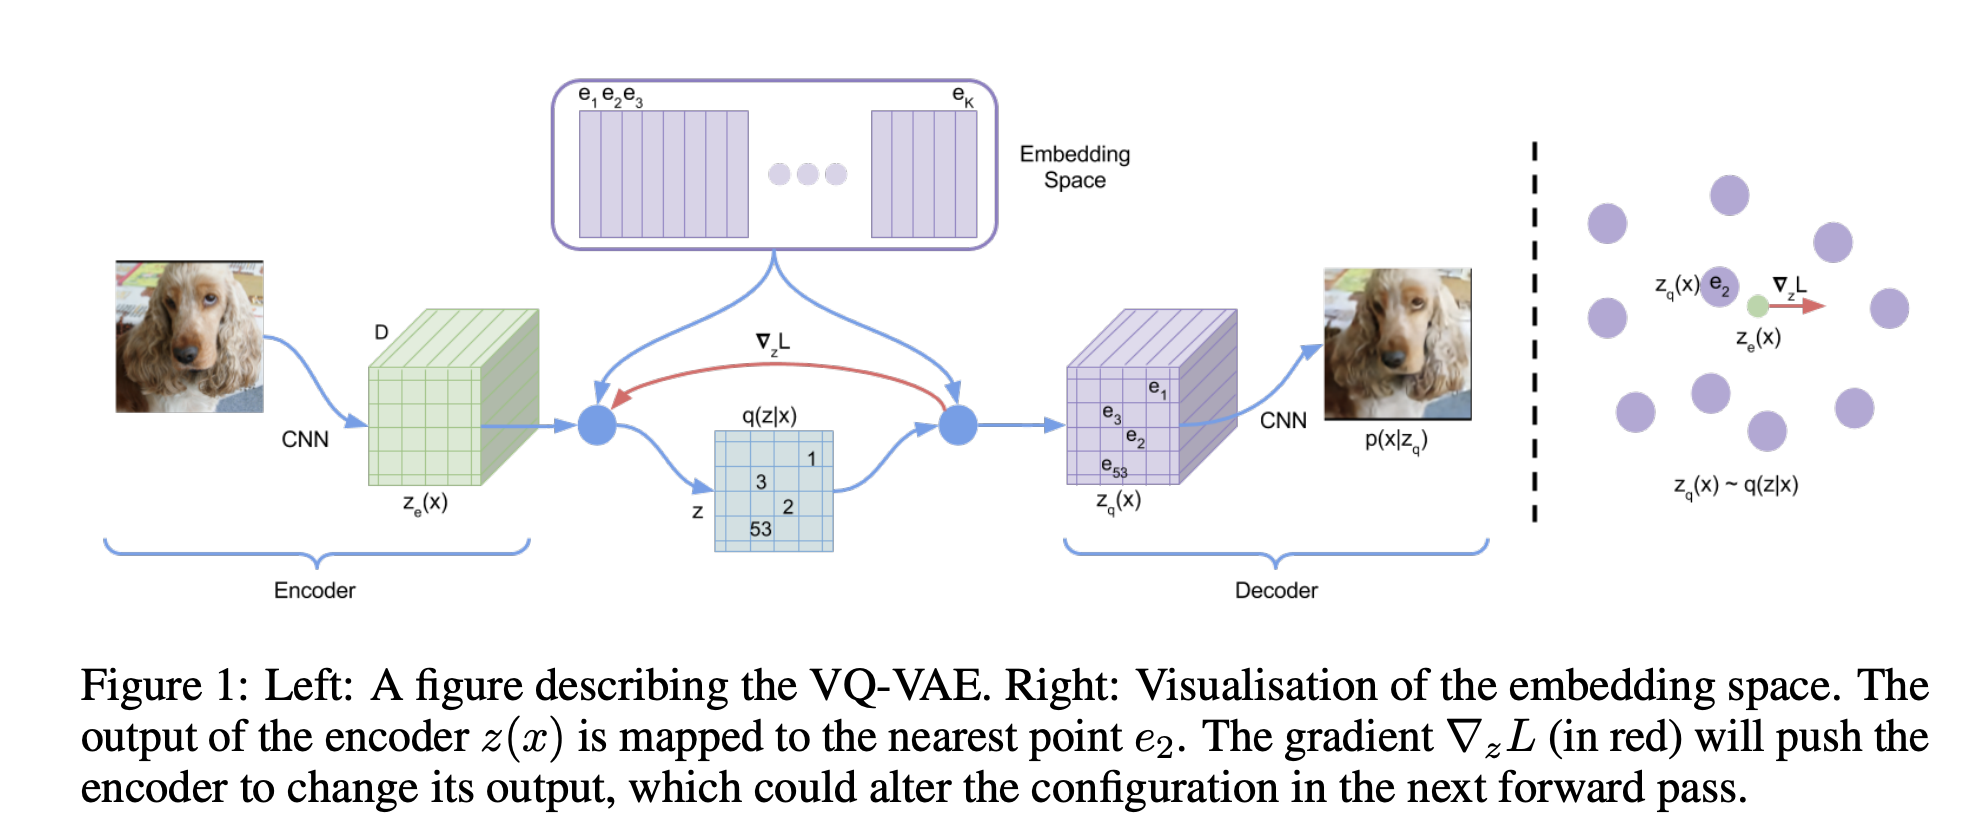

在现实问题中，很多回归问题都被简化成分类问题，VAE的解空间是连续的，在预测分布的时候相对困难。VQ-VAE的思路就是通过离散化，使得解空间更小，模型也不容易过拟合。

可以想象embedding space里有很多个点，一般解空间是 $k \times d$ 维，表示有k个点，每个点的坐标维度是d。图片张量经过encoder之后的特征会和这些点进行比较，选择最近的点作为它的token，然后把相应的编号记入z矩阵。$k \times d$ 维的解空间记录的就是token的编号和对应的向量，就像一个密码本，所以叫codebook。一般 $k=8192$ , $d=512/768$。之后利用z矩阵和codebook就可以重构图像。

VQ-VAE 的损失函数: loss $=$ reconstruction loss + codebook loss + commitment loss.
$$
L=\underline{\log p\left(x \mid z_q(x)\right)}+\underline{\left\|\operatorname{sg}\left[z_e(x)\right]-e\right\|_2^2}+\underline{\beta\left\|z_e(x)-\operatorname{sg}[e]\right\|_2^2}
$$
reconstruction loss: 上式第一项， $\hat{x}$ 与 $x$ 的平方损失或交叉熵损失。用于训练 encoder 和 decoder。

codebook loss: 上式第二项， encoder的输出 $z_e$ 与 隐向量 $e_i$ 的平方损失。 $s g$ 表示 "stop gradient"，也就是不计算那一项的梯度，把它当作常数。用于训练隐空间codebook。 reconstruction loss 训练不到 codebook。 $z_e$ 当作常数，只更新 隐向量 $e_i$ ，所以这个损失函数就是要让隐向量 $e_i$ 尽量接近与它最近的encoder的输出 $z_e$ 。

commitment loss: 上式第三项， encoder的输出 $z_e$ 与 隐向量 $e_i$ 的平方损失。用于训练 encoder。隐向量 $e_i$ 当作常数，只更新 encoder的输出 $z_e$ ，所以这个损失函数就是要让 encoder的输出 $z_e$ 尽量接近 与它最近的隐向量 $e_i$ ，以防止 $z_e$ 在不同的隐向量 $e_i$ 之间波动 (fluctuating)。可以通过调整 $\beta$ 来调整 commitment loss 在 总loss 中的比重，论文中 $\beta=0.25$.

在 VAE 中，希望 隐向量 满足 正态分布(normal distribution)，所以损失函数有个 KL loss；在 VQ-VAE 中，隐向量满足 均匀分布(uniform distribution)，所以 隐向量的分布 $(1 / K, 1 / K ， \ldots . .$. , $1 / K)$ 与 完美的隐向量的分布 $(0, \ldots . ., 0,1,0, \ldots . ., 0)$ 的 KL散度(计算如下) 是个常数( $\log K)$ ，所以损失函数不需要加 KL loss。

需要注意的是，如果只有这部分结构，不足以实现生成，因为codebook还是一个固定的特征，不像VAE可以随机采样。还需要单独训练一个prior网络，OpenAI就结合了GPT和VQ-VAE设计了DALL-E。

BEiT直接用了DALL-E训练好的codebook，单独训练dVAE得到visual tokens矩阵。

#### 为什么不预测被mask掉的像素值？
直接预测被mask掉的像素值可能会促使模型聚焦于短距离依赖和高频细节，而忽略了图像的整体结构和语义信息。这种方法虽然可能在某些任务上取得一定的效果，但可能不适用于所有视觉任务，特别是在需要理解图像整体含义和上下文信息的任务中。

消融实验结果显示，用visual token更好。
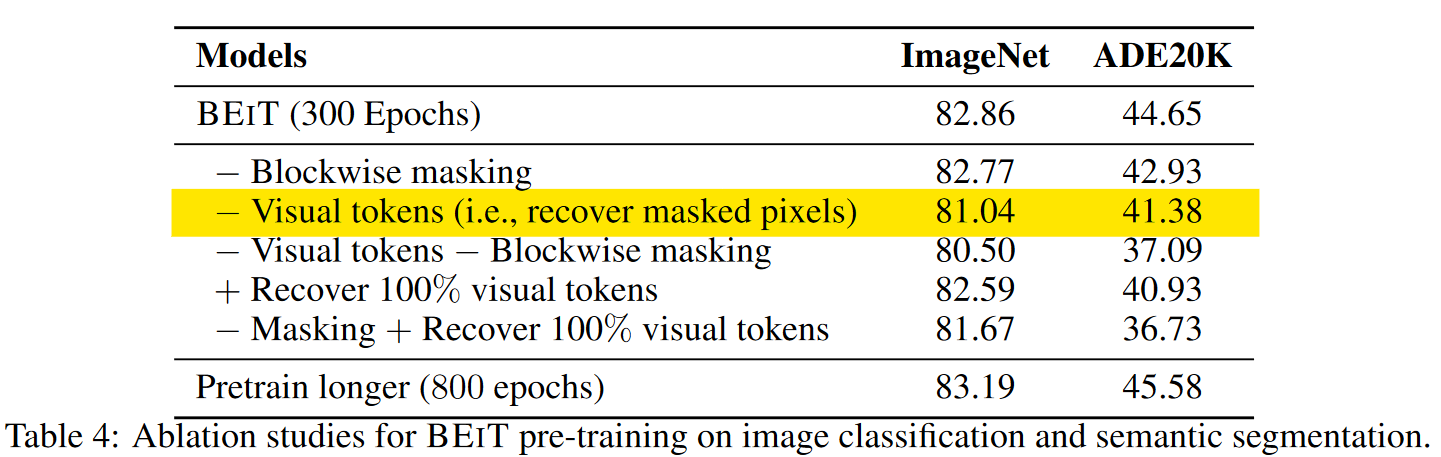

## 其他细节
Masked image modeling (MIM)用两种方式来表示图片：
- image patches表征图片的原始信息，作为输入
- visual tokens相当于图片的字典，作为每个patch的标签

### 将图片表示为 image patches
首先把 $x \in \mathbb{R}^{H \times W \times C}$ 的图像分成 $N=H W / P^2$ 个展平的2D块 $x^p \in \mathbb{R}^{N \times\left(P^2 C\right)}$ 。

式中， $C$ 是 channel 数 (RGB/RGBA)， $(H, W)$ 是输入的分辨率， $(P, P)$ 是 patch 大小。每个 image patch 会被展平成向量并通过线性变换操作 (flattened into vectors and are linearly projected)。这样一来，image 变成了一系列的展平的2D块的序列，这个序列中一共有 $N=H W / P^2$ 个展平的2D 块，每个块的维度是 $\left(P^2 \cdot C\right)$ 。

实际操作时 $P=16, H=W=224$ ，每张图像有 $14 \times 14$ 个patch。

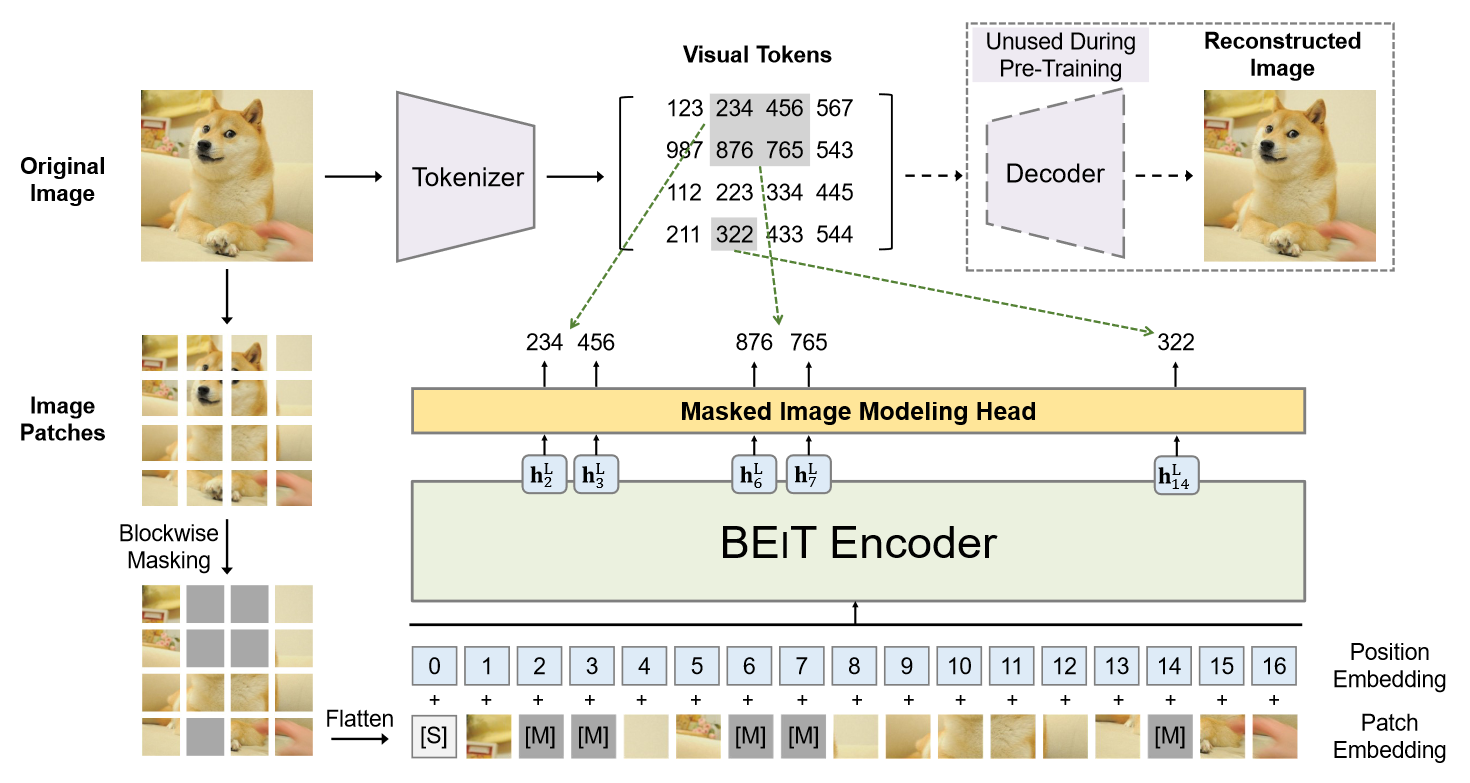

## Masking策略
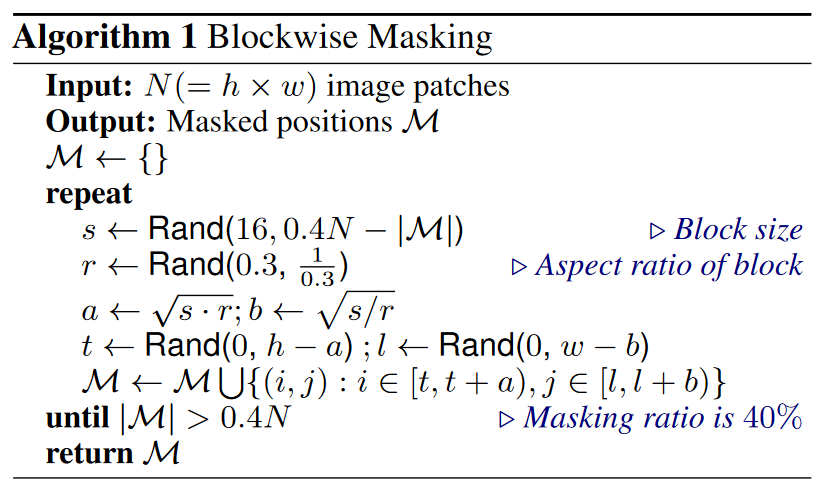

先随机选择一个block的patches进行mask，每个block最小是16，然后随机选择block的长宽比，即横轴方向的patch数量和纵轴方向的patch数量，重复随机选择的过程，直到mask的比例足够。

文章表示，采用blockwise masking比随机masking的效果更好。文章没有解释原因，可能是因为mask一整片使重构的难度更大，没法依赖邻近的patch进行重构，push模型的学习效果更好？从消融实验的结果来看，blockwise masking确实可以帮助pixel level的回归任务克服短距离依赖的问题。
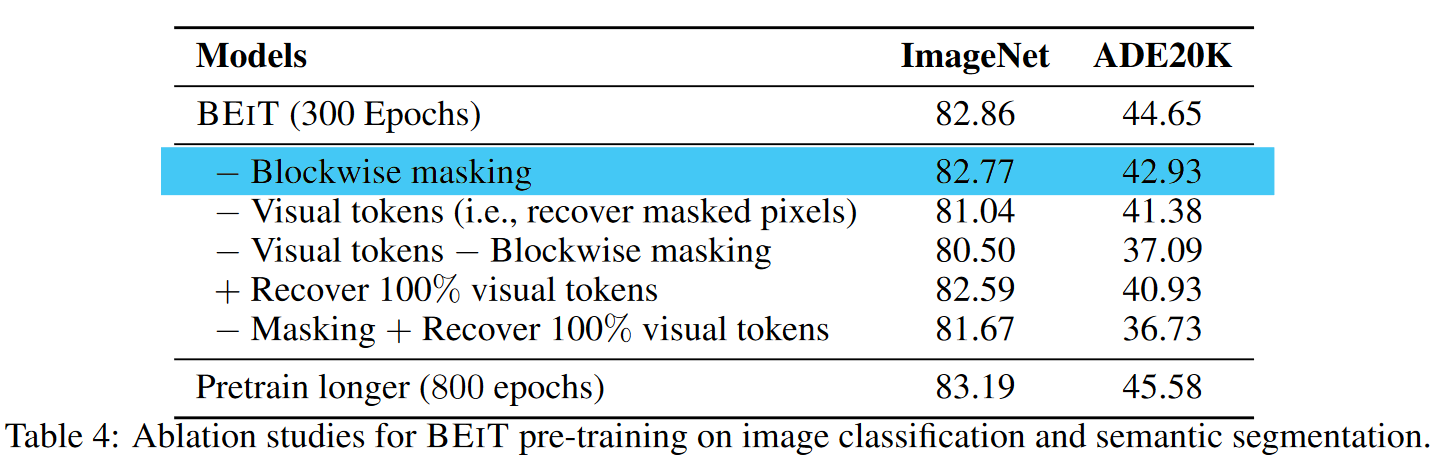

## BEiT和ViT的区别

### ViT (Vision Transformer)
ViT是2020年Google团队提出的将Transformer应用在图像分类的模型，虽然不是第一篇将transformer应用在视觉任务的论文，但是因为其模型“简单”且效果好，可扩展性强（scalable，模型越大效果越好），成为了transformer在CV领域应用的里程碑著作，也引爆了后续相关研究。

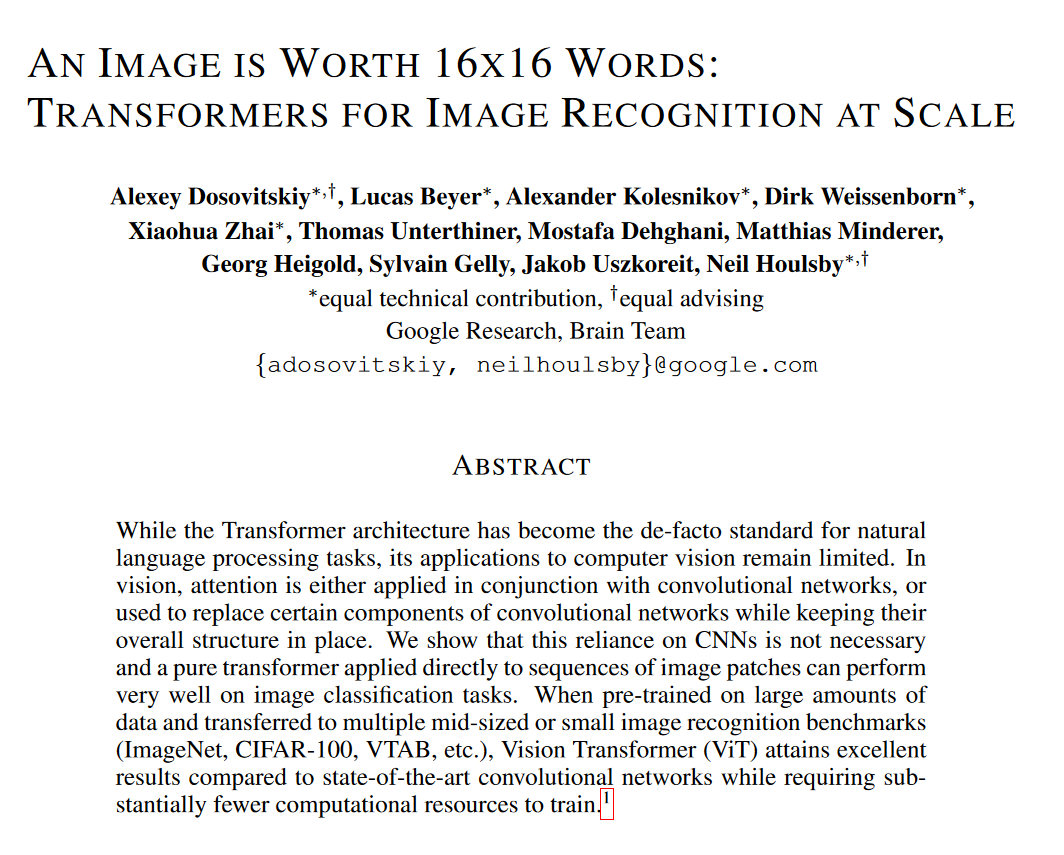

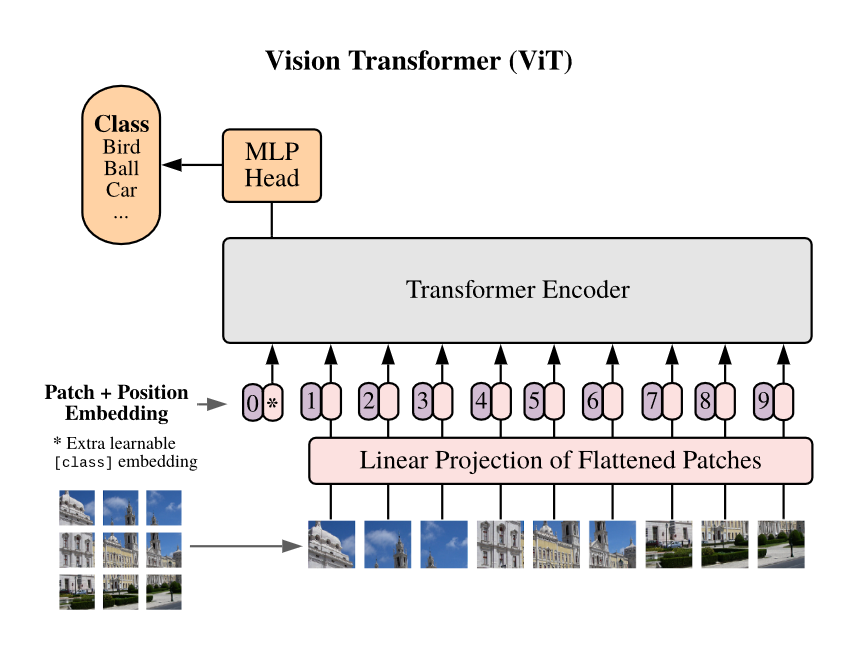

ViT的思路非常简单，输入patch embedding，转化为一个seq2seq的问题，经过transformer encoder，直接做分类问题，没有自监督任务，所以不需要考虑token这些问题。类似ViT的大部分工作的研究重点在于如何让Transformer模型结构适用于CV领域，而BEiT则更偏向于研究如何通过无监督学习的方法学习图像表示，BEiT的成功之处在于直接将NLP中的无监督MLM预训练方法完全引入到CV领域中。


\
参考：

https://arxiv.org/pdf/2106.08254.pdf

【DALL·E 2（内含扩散模型介绍）【论文精读】】 https://www.bilibili.com/video/BV17r4y1u77B/?share_source=copy_web&vd_source=3059fab1053f03e1e91d119db4c50f5b

Self-Supervised Learning 超详细解读 (三)：BEiT：视觉BERT预训练模型 - 科技猛兽的文章 - 知乎
https://zhuanlan.zhihu.com/p/381345343

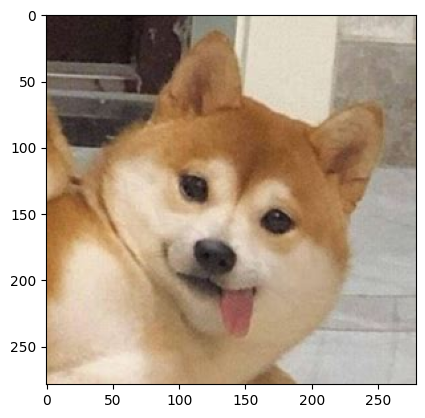

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/home/wn2/workshop/20240410_BEiT/dog.jpg').convert('RGB')
# 图像有RGB三通道和RGBA四通道两种，A是透明度通道，这里不需要
plt.imshow(img)
plt.show()

In [3]:
from torchvision import transforms

pipeline = transforms.Compose([
    transforms.ToTensor()
    ])
img_tensor = pipeline(img)
img_tensor.shape

torch.Size([3, 279, 279])

In [4]:
pipeline = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    ])
img_tensor = pipeline(img)
img_tensor.shape

torch.Size([3, 224, 224])

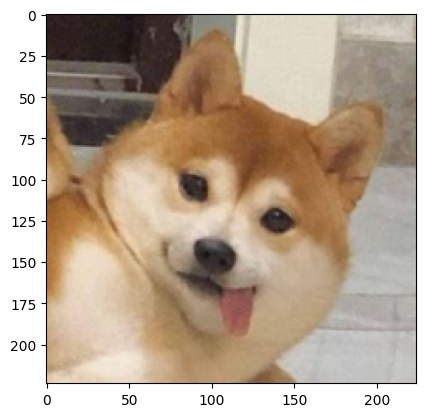

In [5]:
img_transformed = transforms.ToPILImage()(img_tensor)
plt.imshow(img_transformed)
plt.show()

In [6]:
img_tensor.numpy().shape

(3, 224, 224)

In [7]:
from patchify import patchify

patches = patchify(img_tensor.numpy(), (16, 16), step=16)
patches

ValueError: `window_shape` is incompatible with `arr_in.shape`